In [51]:
import os, sys
import numpy as np

from pathlib import Path

from astropy.io import fits, ascii
from astropy.table import Table, Column, hstack, vstack, join
from astropy.cosmology import FlatLambdaCDM

from scipy import interpolate
import scipy.stats as stats

import itertools as it

sys.path.append("./py")
from utils import *

from params import BASEDIR, DATADIR, SIMDIR, MOCKDIR, H0, Om0
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

from params import get_zsnap_data, get_boxsize, get_abs_mag_lim, get_abs_mag_bins_clust, get_sham_var_bins
from params import nbins, rp_min, rp_max, rp_bins, rp_mids, bin_file, bin_file_comoving

import Corrfunc
from Corrfunc.theory.wp import wp as wp_corrfunc


#-- convert to Mpc/h for use with simulation
rp_min, rp_max, rp_bins, rp_mids = (H0/100.)*np.array([rp_min, rp_max, rp_bins, rp_mids])


In [54]:
def _mock_wp_fast(cat, boxsize=None, sigma_los=None, nthreads=1, pimax=150., bin_file=None, N_iter=1,
                  down_sample=False, quiet=False):
    """
    Corrfunc wp (autocorrelation) calculation of unpadded box using analytic randoms
    """
    out = []
    for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
        xx, yy, zz = cat[u], cat[v], cat[w]

        z_scatter = np.array([np.random.normal(zz, sigma_los, len(zz)) for idx in range(N_iter)])
        z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
        z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

        if type(down_sample)==int:
            ds = down_sample
            out.append([wp_corrfunc(boxsize, pimax, nthreads, bin_file, xx[::ds], yy[::ds], z_s[::ds],
                                    output_rpavg=False)["wp"] for z_s in z_scatter])
        else:
            out.append([wp_corrfunc(boxsize, pimax, nthreads, bin_file, xx, yy, z_s, output_rpavg=False)["wp"] for z_s in z_scatter])

    out = np.concatenate(out).T

    return out



def _run_mock_wp_fast(cat=None, BASEDIR=None, sim_tag=None, zmag_tag=None, abs_mag_lim_tag=None,
                      abs_mag_bin_tag=None, sigma_sham_tag=None, bin_file=bin_file, zsnap_tag=None, d=None,
                      pimax=None, sigma_los_const_array=None, quiet=True):
    save_path = f"{BASEDIR}/clustering/mocks/{sim_tag}/{sham_tag}/{zmag_tag}/{abs_mag_lim_tag}/{abs_mag_bin_tag}/{sigma_sham_tag}"
    Path( save_path ).mkdir(parents=True, exist_ok=True)

    save_as = f"{save_path}/{zsnap_tag}_{d}_GXG_pimax{int(pimax)}.npy"
    if os.path.exists( save_as ):
        wp_all_sigma_los = np.load(save_as, allow_pickle=True).item()
    else:
        wp_all_sigma_los = {}
    for sigma_los in sigma_los_const_array:
        key = f"sigma_los_{sigma_los}"
#         if key in wp_all_sigma_los.keys():
#             if not quiet:
#                 print(f"sigma_los = {sigma_los} Mpc/h found; skipping...")
#         else:
        wp_this_sigma_los = _mock_wp_fast(cat, boxsize=boxsize, pimax=pimax, bin_file=bin_file, quiet=quiet, sigma_los=sigma_los)
        wp  = np.mean(wp_this_sigma_los, axis=1)
        std = np.std(wp_this_sigma_los, axis=1)
        wp_all_sigma_los[key] = dict(rp_mids=rp_mids, wp=wp, std=std)
            
    return wp_all_sigma_los
    # np.save( save_as, wp_all_sigma_los, allow_pickle=True )
    

In [3]:
iter_over_sigma_const = True
n_mag_bins_clust = 4

quiet = False

#-- specify clustering to calculate (for constant scatter values)
pimax        = 150.
h            = H0/100.
cross        = "GXG"
zmag_lim     = 20.7
if iter_over_sigma_const:
    clust_mag_binned = True
    clust_full_mock  = False

#-- load galaxy parent sample statistics
#-- first define relelvant parameter values
band = "Mz" #sys.argv[1] # MW1 or Mr
d    = "south"
zmin = 0.4 #float(sys.argv[2]) # 0.4, 0.5, 0.6


sim_tag      = "mdpl2"
sham_tag     = "vpeak" #-- vmax, vmax\@mpeak
quiet        = True if (("-q" in sys.argv) | ("--quiet" in sys.argv)) else False
sham_tag_min = 125  #-- km/s

#-- ranges for testing constant sigma for mag-Vcirc scatter and LOS position scatter
if iter_over_sigma_const:
    if band=="Mr":
        # sigma_const_array = np.round(np.arange(0.01,0.61,0.01),2)  # finer bins (narrower range)
        sigma_const_array = np.round(np.arange(0.0,1.01,0.1),1)  # coarse bins
    elif band=="Mz":
        # sigma_const_array = np.round(np.arange(0.01,0.61,0.01),2)  # finer bins (narrower range)
        sigma_const_array = np.round(np.arange(0.0,1.01,0.1),1)  # coarse bins
    elif band=="MW1":
        # sigma_const_array = np.round(np.arange(0.01,0.61,0.01),2)  # finer bins (narrower range)
        sigma_const_array = np.round(np.arange(0.0,1.01,0.1),1)  # coarse bins
    else:
        raise Exception()
    sigma_los_const_array = np.arange(0,121,10)
    print(f"\n{now()} Computing wp for constant parameter values in magnitude bins...")
else:
    raise Exception()


"""########## BEGIN HOUSEKEEPING ##########"""
z_snaps, snap_nums, snaps = get_zsnap_data(sim_tag)

hist_idx = [len(snaps)-i for i in snap_nums]
boxsize  = get_boxsize(sim_tag)
vol_sim  = boxsize**3
a_snaps  = [snaps["scale"][snaps["snapnum"]==sn].data[0] for sn in snap_nums]

sham_var_bins, sham_var_cens = get_sham_var_bins(sham_tag)

zrange      = (np.round(zmin,1), np.round(zmin+0.1,1))
zmin, zmax  = zrange
cat_tag     = get_cat_tag(d,zrange)
abs_mag_lim = get_abs_mag_lim(zmin, band)
zsim        = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
zsnap_tag   = get_zsnap_tag(zsim)
zmag_tag    = get_zmag_tag(zmag_lim)

MW1lim = get_abs_mag_lim(zmin,"MW1")
Mrlim  = get_abs_mag_lim(zmin,"Mr")
Mzlim  = get_abs_mag_lim(zmin,"Mz")
if band=="MW1":
    abs_mag_lim_tag = get_MW1_tag(MW1lim)
elif band=="Mr":
    abs_mag_lim_tag = get_Mr_tag(Mrlim)
elif band=="Mz":
    abs_mag_lim_tag = get_Mz_tag(Mzlim)
else:
    raise Exception()

abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band, nbins=n_mag_bins_clust)
mag_bin_cens       = [round(np.mean(abs_mag_bins_clust[k:k+2]),3) for k in range(len(abs_mag_bins_clust)-1)]

lf_name = f"{DATADIR}/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"
color_cdf_name = f"{DATADIR}/stats/cdf_r-{band[1:]}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"

lum_func  = np.load(lf_name, allow_pickle=True).item()
color_cdf = Table(np.load(color_cdf_name))

lum_func_full = np.load(f"{DATADIR}/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_full.npy", allow_pickle=True).item()
"""########### END HOUSEKEEPING ###########"""


[18:23:26] Computing wp for constant parameter values in magnitude bins...


'########### END HOUSEKEEPING ###########'

In [4]:
#==========================#
# load simulation snapshot #
#==========================#
a     = snaps["scale"][snaps["redshift"]==zsim][0]
scale = f"{a:.4f}"
scale = scale.replace(".","p")

snap_fname = f"{SIMDIR}/{sim_tag}/CATALOGS/vpeakmin{int(sham_tag_min)}/a{scale}.npy"
if os.path.exists( snap_fname ):
    if not quiet:
        print(f"\n{now()} Loading simulation shapshot (zsim = {zsim}; {sham_tag} > {sham_tag_min})...")
    halocat = Table( np.load(snap_fname) )
else:
    # raise Exception(f"\n{now()} NOT FOUND: {test_fname}")
    from halocat_history import read_halocat
    if not quiet:
        print(f"\n{now()} Loading simulation shapshot (full)...")
    halocat  = read_halocat(f"{SIMDIR}/{sim_tag}/CATALOGS/hlist_{scale}.npy", quiet=quiet)
    save_dir = f"{SIMDIR}/{sim_tag}/CATALOGS/{sham_tag}min{int(sham_tag_min)}"
    if not quiet:
        print(f"save_dir = {save_dir}")
    Path( save_dir ).mkdir(parents=True, exist_ok=True)
    np.save( test_fname, halocat[halocat[sham_tag] >= sham_tag_min] )

if not quiet:
    print(f"\n{now()} Sorting halo catalog by {sham_tag}...")
halocat.sort( sham_tag )


#==========================================================================#
# add parent acc_scale and/or parent_mvir to simulation snapshot if needed #
#==========================================================================#
if ("acc_scale" not in halocat.colnames) | ("parent_mvir" not in halocat.colnames):
    print(f"\n{now()} Adding 'parent_mvir' to halocat...")
    supercat = Table(np.load(f"{SIMDIR}/{sim_tag}/CATALOGS/{sham_tag}min{sham_tag_min}/a{scale}.npy"))
    if "halo_id" not in supercat.colnames:
        supercat.rename_column("id", "halo_id")
    if "halo_id" not in halocat.colnames:
        halocat.rename_column("id", "halo_id")
    
    #-- add parent_mvir to halocat if needed
    if ("parent_mvir" not in halocat.colnames):
        halo_id   = supercat["halo_id"].data # unique
        halo_upid = supercat["upid"].data # not unique
        
        upid_idx, id_idx = crossmatch(halo_upid, halo_id, skip_bounds_checking=True)

        supercat.add_column(Column(np.zeros(len(supercat)), name="parent_mvir"))
        supercat["parent_mvir"][upid_idx] = supercat["mvir"][id_idx]
        
        parent_halo_mask = (supercat["upid"] == -1)
        supercat["parent_mvir"][parent_halo_mask] = supercat["mvir"][parent_halo_mask]

        parent_mvir_cat = Table(data=np.array([supercat["halo_id"].data, supercat["upid"].data, supercat["parent_mvir"].data]).T, dtype=(int,int,int), names=("halo_id","upid","parent_mvir"))

        halocat = join(halocat, parent_mvir_cat, join_type="inner", keys=("halo_id","upid"))
        del parent_mvir_cat
        
    #-- add acc_scale to halocat if needed
    if ("acc_scale" not in halocat.colnames):
        print(f"\n{now()} Adding 'acc_scale' to halocat...")
        for c in supercat.colnames:
            if (c != "halo_id") and (c != "acc_scale"):
                supercat.remove_column(c)
        halocat = join(halocat, supercat, join_type="inner", keys="halo_id")
    del supercat
    
    print(f"\n{now()} Saving...")
    np.save(snap_fname, halocat)


#=============================================================#
# get value of nh = nh( sham_var ) for each value of sham_var #
#=============================================================#
halocat  = halocat[np.log10(halocat["parent_mvir"]) >= 11.5]
sham_var = halocat[sham_tag]

#-- halo number counts in bins of (log_)sham_var
H,_ = np.histogram( np.log10(sham_var), bins=sham_var_bins )

#-- halo abundance versus (min log_)sham_var
cdf_log_sham_var = np.max(np.cumsum(H))-np.cumsum(H)

#-- interpolation function for nh of (log_)sham_var
nh_of_log_sham_var = interpolate.interp1d(sham_var_cens, np.array(cdf_log_sham_var)/vol_sim, fill_value="extrapolate")

#-- inferred halo number densities for sham_var values
nh_inferred = nh_of_log_sham_var( np.log10(sham_var) )

cname = "nh_inferred"
if cname in halocat.colnames:
    halocat.remove_column( cname )
halocat.add_column( Column(nh_inferred, name=cname) )


#================================================================#
# infer absolute magnitudes from inferred halo numbder densities #
# abs_mag = abs_mag( ngal_eff=nh )                               #
#================================================================#
abs_mag_bins = lum_func_full["abs_mag_bins"]
ngal_eff     = lum_func_full["ng_eff"]

#-- interpolation function for abs_mag of ngal_eff
abs_mag_of_ngal_eff = interpolate.interp1d(ngal_eff, abs_mag_bins[::-1], fill_value="extrapolate")

#-- mdoel magnitudes assigned according to nh_inferred WITHOUT any scatter implementation
nh_inferred      = halocat["nh_inferred"]
abs_mag_inferred = abs_mag_of_ngal_eff( nh_inferred )

#-- add inferred magnitudes (with MONOTONIC Vcirc correspondence) to halo catalog
cname = f"{band}_no_scatter"
if cname in halocat.colnames:
    halocat.remove_column( cname )
halocat.add_column( Column(abs_mag_inferred, name=cname) )
halocat = halocat[halocat[cname] > -np.inf]


[18:23:26] Loading simulation shapshot (zsim = 0.42531; vpeak > 125)...

[18:23:34] Sorting halo catalog by vpeak...


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [5]:
#====================================#
# add scatter to inferred magnitudes #
# compute and save mock clustering   #
#====================================#
nsig_clip = 2.5

# if iter_over_sigma_const:
# for sigma_sham in sigma_const_array:
sigma_sham = 0.3
sc = str(round(sigma_sham,2)).replace(".","p")
sigma_sham_tag = f"sigma_sham_const{sc}"

print(f"\n{now()} Scattering inferred magnitudes (sigma = {sigma_sham})...")
abs_mag_inferred = halocat[f"{band}_no_scatter"]

abs_mag_inferred_scattered = stats.truncnorm.rvs(-nsig_clip, nsig_clip, abs_mag_inferred, sigma_sham)

cname = f"{band}_scattered"
if cname in halocat.colnames:
    halocat.remove_column( cname )
halocat.add_column( Column(abs_mag_inferred_scattered, name=cname) )

if not quiet:
    print(f"\n{now()} Sorting halo catalog by scattered {band}...")
halocat.sort( f"{band}_scattered" )

abs_mag_inferred_sorted = halocat.copy()[f"{band}_no_scatter"]
abs_mag_inferred_sorted.sort()

if band in halocat.colnames:
    halocat.remove_column( band )
halocat.add_column( Column(abs_mag_inferred_sorted, name=band) )

#-- sort catalog by model magnitude       
halocat.sort( band )

#-- number of (sub)halos to select based on number density from data
Nhalo_select = int(np.max(lum_func["ng_eff"])*vol_sim)

halocat_select = halocat[:Nhalo_select]



[18:24:29] Scattering inferred magnitudes (sigma = 0.3)...

[18:24:30] Sorting halo catalog by scattered Mz...


In [95]:
sigma_los_const_array = (0,50,100,110) # np.arange(0,121,10)

kwargs = dict(BASEDIR=BASEDIR, sim_tag=sim_tag, zmag_tag=zmag_tag, abs_mag_lim_tag=abs_mag_lim_tag,
              sigma_sham_tag=sigma_sham_tag, zsnap_tag=zsnap_tag, d=d, pimax=pimax,
              sigma_los_const_array=sigma_los_const_array, quiet=quiet)


In [96]:
%%time

abs_mag = halocat_select[band]
bfile   = bin_file_comoving

for i in range(len(abs_mag_bins_clust)-1):
    if i==1:
        mag_min, mag_max = abs_mag_bins_clust[i:i+2]
        abs_mag_bin_tag  = abs_mag_bin_tags[i]
        if not quiet:
            print(f"\n{now()} ...{band} bin {i+1} / {len(abs_mag_bins_clust)-1}: {abs_mag_bin_tag}")
        mag_mask = (abs_mag > mag_min) & (abs_mag <= mag_max)
        if not quiet:
            print(f"N = {len( halocat_select[mag_mask] )}")
        kwargs["cat"] = halocat_select[mag_mask]
        kwargs["abs_mag_bin_tag"] = abs_mag_bin_tag
        kwargs["bin_file"] = bfile
        out = _run_mock_wp_fast(**kwargs)



[23:26:36] ...Mz bin 2 / 4: Mzn22p35-n22p1
N = 353128
CPU times: user 8.71 s, sys: 46.8 ms, total: 8.75 s
Wall time: 8.75 s


In [110]:
#-- data        
fpath_data    = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/Mzn22p35-n22p1"
wp_fname_data = f"{fpath_data}/wp/{get_cat_tag(d, zrange)}_{cross}_pimax{int(pimax)}.txt"

h = 0.6777

data = ascii.read(wp_fname_data)

rp_cen = h*data["rp_cen"]
wp     = h*data["wp"]
wp_err = h*np.sqrt(data["wp_err"])


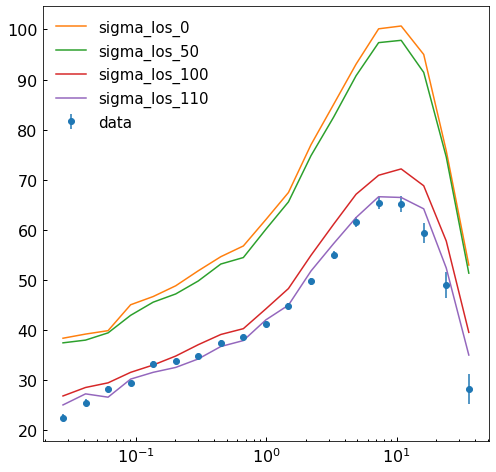

In [111]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

#-- plot data
ax.errorbar(rp_cen, rp_cen*wp, yerr=rp_cen*wp_err, label="data", ls="", marker="o")

#-- plot models
for k in list(out.keys()):
    ax.plot(rp_mids, rp_mids*(h*out[k]["wp"]), label=k)
    ############## WHY THIS ^h^? @###################
ax.semilogx()

ax.legend()
plt.show()


In [8]:
# %%time

# abs_mag_bin_tag = "no_abs_mag_bins"
# if not quiet:
#     print(f"{now()} ...full mock: {abs_mag_bin_tag}")
# kwargs["cat"] = halocat_select       
# kwargs["abs_mag_bin_tag"] = abs_mag_bin_tag        

# out = _run_mock_wp_fast(**kwargs)
